In [1]:
## Training Script
# Run this to train a bone suppression network ResNet-BS, introduced by Rajaraman et al. 2021.
# 
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics
from sklearn.model_selection import KFold

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, ConcatDataset
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn
import torch.optim as optim

import datasets, custom_transforms, RajaramanModel, pytorch_msssim

flag_debug = False
flag_load_previous_save = False

# Input Directories
#data_BSE = "D:/data/JSRT/augmented/train/target/"
#data_normal = "D:/data/JSRT/augmented/train/source/"
data_BSE = Path('G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/trainValidate_LowRes/suppressed/')
data_normal = Path('G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/trainValidate_LowRes/normal/')
#data_val_normal = 'G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/validate/normal'
#data_val_BSE = 'G:/DanielLam/JSRT/HQ_JSRT_and_BSE-JSRT/177-20-20 split/validate/suppressed/'

# Save directories:
output_save_directory = Path("./runs/Rajaraman_ResNet/177-20-20/10KFold_217perEpoch")
output_save_directory.mkdir(parents=True, exist_ok=True)
PATH_SAVE_NETWORK_INTERMEDIATE = os.path.join(output_save_directory, 'network_intermediate_{}.tar' )
PATH_SAVE_NETWORK_FINAL = os.path.join(output_save_directory, 'network_final_{}.pt')

# Image Size:
image_spatial_size = (480, 480)
_batch_size = 2
split_k_folds=10
sample_keys_images = ["source", "boneless"]

# Optimisation
lr_ini = 0.001
beta1 = 0.9
beta2 = 0.999

# Training
total_num_epochs_paper = 200
epoch_factor = 1 #22.8764
total_num_epochs = int(epoch_factor*total_num_epochs_paper)

# Weight Initialisation
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0., 0.02)
        #nn.init.kaiming_normal_(m.weight.data,0)
        try:
            nn.init.constant_(m.bias.data, 0.)
        except:
            pass
    if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.InstanceNorm2d):
        if m.affine:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.)

## Code for putting things on the GPU
ngpu = 1 #torch.cuda.device_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)
if (torch.cuda.is_available()):
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    if ngpu ==1:
        device=torch.device('cuda:1')

cuda
GeForce RTX 2080 Ti


In [2]:
# Current date:
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Data Loader
original_key = "source"
target_key = "boneless"
discriminator_keys_images = [original_key, target_key]

#ds_training = datasets.JSRT_CXR(data_normal, data_BSE,
#                         transform=tvtransforms.Compose([
#                             # custom_transforms.HistogramEqualisation(discriminator_keys_images),-- check if training data is already equalised
#                             custom_transforms.Resize(discriminator_keys_images, image_spatial_size),
#                             custom_transforms.ToTensor(discriminator_keys_images),
#                             ])
#                      )
#ds_val = datasets.JSRT_CXR(data_val_normal, data_val_BSE,
#                         transform=tvtransforms.Compose([
#                             #custom_transforms.HistogramEqualisation(discriminator_keys_images),
#                             custom_transforms.Resize(discriminator_keys_images, image_spatial_size),
#                             custom_transforms.ToTensor(discriminator_keys_images),
#                             ])
#                      )



In [3]:
# Rajaraman Loss
def criterion_Rajaraman(testImage, referenceImage, alpha=0.84):
    """
    Generates a loss over a mini-batch of images.
    Outputs scalars.
    Rajaraman, S., Zamzmi, G., Folio, L., Alderson, P., & Antani, S. (2021). Chest X-Ray Bone Suppression for Improving Classification of Tuberculosis-Consistent Findings. In Diagnostics (Vol. 11, Issue 5). https://doi.org/10.3390/diagnostics11050840
    """
    mae = nn.L1Loss() # L2 used for easier optimisation c.f. L1
    mae_loss = mae(testImage, referenceImage)
    msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1, normalize='relu')
    msssim_loss = 1 - msssim(testImage, referenceImage)
    total_loss = (1-alpha)*mae_loss + alpha*msssim_loss
    return total_loss, mae_loss, msssim_loss

boneless
Fold 1
FLAG: NO CHECKPOINT LOADED.
0.001
[0/200][0/89]	Total Loss: 0.7445	MAELoss: 0.3417	MSSSIM Loss: 0.8212
[0/200][1/89]	Total Loss: 0.5659	MAELoss: 0.3097	MSSSIM Loss: 0.6147
[0/200][2/89]	Total Loss: 0.5465	MAELoss: 0.2771	MSSSIM Loss: 0.5978
[0/200][3/89]	Total Loss: 0.4427	MAELoss: 0.2620	MSSSIM Loss: 0.4772
[0/200][4/89]	Total Loss: 0.3007	MAELoss: 0.1678	MSSSIM Loss: 0.3260
[0/200][5/89]	Total Loss: 0.3490	MAELoss: 0.2718	MSSSIM Loss: 0.3637
[0/200][6/89]	Total Loss: 0.3133	MAELoss: 0.1506	MSSSIM Loss: 0.3443
[0/200][7/89]	Total Loss: 0.2097	MAELoss: 0.2536	MSSSIM Loss: 0.2014
[0/200][8/89]	Total Loss: 0.2371	MAELoss: 0.1905	MSSSIM Loss: 0.2460
[0/200][9/89]	Total Loss: 0.1794	MAELoss: 0.2561	MSSSIM Loss: 0.1648
[0/200][10/89]	Total Loss: 0.1442	MAELoss: 0.1284	MSSSIM Loss: 0.1472
[0/200][11/89]	Total Loss: 0.1196	MAELoss: 0.0938	MSSSIM Loss: 0.1245
[0/200][12/89]	Total Loss: 0.1141	MAELoss: 0.0762	MSSSIM Loss: 0.1213
[0/200][13/89]	Total Loss: 0.2345	MAELoss: 0.1609	

FLAG: NO CHECKPOINT LOADED.
0.001
[0/200][0/89]	Total Loss: 0.7162	MAELoss: 0.3250	MSSSIM Loss: 0.7907
[0/200][1/89]	Total Loss: 0.6091	MAELoss: 0.2805	MSSSIM Loss: 0.6717
[0/200][2/89]	Total Loss: 0.5446	MAELoss: 0.2719	MSSSIM Loss: 0.5966
[0/200][3/89]	Total Loss: 0.3410	MAELoss: 0.1624	MSSSIM Loss: 0.3750
[0/200][4/89]	Total Loss: 0.2570	MAELoss: 0.2266	MSSSIM Loss: 0.2628
[0/200][5/89]	Total Loss: 0.3211	MAELoss: 0.3008	MSSSIM Loss: 0.3249
[0/200][6/89]	Total Loss: 0.1586	MAELoss: 0.3200	MSSSIM Loss: 0.1279
[0/200][7/89]	Total Loss: 0.2148	MAELoss: 0.1757	MSSSIM Loss: 0.2222
[0/200][8/89]	Total Loss: 0.1752	MAELoss: 0.2093	MSSSIM Loss: 0.1687
[0/200][9/89]	Total Loss: 0.1298	MAELoss: 0.1364	MSSSIM Loss: 0.1285
[0/200][10/89]	Total Loss: 0.1296	MAELoss: 0.0796	MSSSIM Loss: 0.1391
[0/200][11/89]	Total Loss: 0.1311	MAELoss: 0.0958	MSSSIM Loss: 0.1378
[0/200][12/89]	Total Loss: 0.0849	MAELoss: 0.0859	MSSSIM Loss: 0.0847
[0/200][13/89]	Total Loss: 0.0591	MAELoss: 0.0850	MSSSIM Loss: 0.0

FLAG: NO CHECKPOINT LOADED.
0.001
[0/200][0/89]	Total Loss: 0.6980	MAELoss: 0.2837	MSSSIM Loss: 0.7769
[0/200][1/89]	Total Loss: 0.6449	MAELoss: 0.2768	MSSSIM Loss: 0.7150
[0/200][2/89]	Total Loss: 0.5332	MAELoss: 0.2819	MSSSIM Loss: 0.5810
[0/200][3/89]	Total Loss: 0.3222	MAELoss: 0.2324	MSSSIM Loss: 0.3394
[0/200][4/89]	Total Loss: 0.1951	MAELoss: 0.3798	MSSSIM Loss: 0.1599
[0/200][5/89]	Total Loss: 0.4002	MAELoss: 0.4119	MSSSIM Loss: 0.3979
[0/200][6/89]	Total Loss: 0.3701	MAELoss: 0.4135	MSSSIM Loss: 0.3619
[0/200][7/89]	Total Loss: 0.4040	MAELoss: 0.2659	MSSSIM Loss: 0.4303
[0/200][8/89]	Total Loss: 0.1772	MAELoss: 0.2669	MSSSIM Loss: 0.1601
[0/200][9/89]	Total Loss: 0.2080	MAELoss: 0.2020	MSSSIM Loss: 0.2091
[0/200][10/89]	Total Loss: 0.2348	MAELoss: 0.1619	MSSSIM Loss: 0.2487
[0/200][11/89]	Total Loss: 0.1840	MAELoss: 0.1444	MSSSIM Loss: 0.1916
[0/200][12/89]	Total Loss: 0.1636	MAELoss: 0.0992	MSSSIM Loss: 0.1759
[0/200][13/89]	Total Loss: 0.1374	MAELoss: 0.0966	MSSSIM Loss: 0.1

FLAG: NO CHECKPOINT LOADED.
0.001
[0/200][0/89]	Total Loss: 0.6922	MAELoss: 0.3102	MSSSIM Loss: 0.7650
[0/200][1/89]	Total Loss: 0.5813	MAELoss: 0.3098	MSSSIM Loss: 0.6330
[0/200][2/89]	Total Loss: 0.5638	MAELoss: 0.2549	MSSSIM Loss: 0.6227
[0/200][3/89]	Total Loss: 0.4402	MAELoss: 0.2516	MSSSIM Loss: 0.4761
[0/200][4/89]	Total Loss: 0.2613	MAELoss: 0.2715	MSSSIM Loss: 0.2594
[0/200][5/89]	Total Loss: 0.3467	MAELoss: 0.3604	MSSSIM Loss: 0.3441
[0/200][6/89]	Total Loss: 0.2896	MAELoss: 0.4524	MSSSIM Loss: 0.2586
[0/200][7/89]	Total Loss: 0.3928	MAELoss: 0.2374	MSSSIM Loss: 0.4224
[0/200][8/89]	Total Loss: 0.2158	MAELoss: 0.1939	MSSSIM Loss: 0.2199
[0/200][9/89]	Total Loss: 0.2517	MAELoss: 0.1858	MSSSIM Loss: 0.2643
[0/200][10/89]	Total Loss: 0.2806	MAELoss: 0.2022	MSSSIM Loss: 0.2955
[0/200][11/89]	Total Loss: 0.1952	MAELoss: 0.1696	MSSSIM Loss: 0.2001
[0/200][12/89]	Total Loss: 0.1317	MAELoss: 0.1247	MSSSIM Loss: 0.1330
[0/200][13/89]	Total Loss: 0.1185	MAELoss: 0.0893	MSSSIM Loss: 0.1

FLAG: NO CHECKPOINT LOADED.
0.001
[0/200][0/89]	Total Loss: 0.8861	MAELoss: 0.2882	MSSSIM Loss: 1.0000
[0/200][1/89]	Total Loss: 0.6624	MAELoss: 0.2821	MSSSIM Loss: 0.7348
[0/200][2/89]	Total Loss: 0.5654	MAELoss: 0.2738	MSSSIM Loss: 0.6209
[0/200][3/89]	Total Loss: 0.3911	MAELoss: 0.1762	MSSSIM Loss: 0.4320
[0/200][4/89]	Total Loss: 0.2113	MAELoss: 0.3910	MSSSIM Loss: 0.1770
[0/200][5/89]	Total Loss: 0.3726	MAELoss: 0.4072	MSSSIM Loss: 0.3660
[0/200][6/89]	Total Loss: 0.3980	MAELoss: 0.4169	MSSSIM Loss: 0.3944
[0/200][7/89]	Total Loss: 0.3470	MAELoss: 0.3348	MSSSIM Loss: 0.3493
[0/200][8/89]	Total Loss: 0.1937	MAELoss: 0.3141	MSSSIM Loss: 0.1708
[0/200][9/89]	Total Loss: 0.2148	MAELoss: 0.2509	MSSSIM Loss: 0.2080
[0/200][10/89]	Total Loss: 0.1759	MAELoss: 0.2358	MSSSIM Loss: 0.1645
[0/200][11/89]	Total Loss: 0.1450	MAELoss: 0.1561	MSSSIM Loss: 0.1429
[0/200][12/89]	Total Loss: 0.1178	MAELoss: 0.1052	MSSSIM Loss: 0.1202
[0/200][13/89]	Total Loss: 0.1120	MAELoss: 0.0863	MSSSIM Loss: 0.1

1e-05
1e-05
Saved Intermediate: runs\Rajaraman_ResNet\177-20-20\10KFold_217perEpoch\network_intermediate_5.tar
Fold 6
FLAG: NO CHECKPOINT LOADED.
0.001
[0/200][0/89]	Total Loss: 0.7860	MAELoss: 0.2895	MSSSIM Loss: 0.8806
[0/200][1/89]	Total Loss: 0.6621	MAELoss: 0.2695	MSSSIM Loss: 0.7369
[0/200][2/89]	Total Loss: 0.4872	MAELoss: 0.2260	MSSSIM Loss: 0.5369
[0/200][3/89]	Total Loss: 0.3468	MAELoss: 0.2581	MSSSIM Loss: 0.3637
[0/200][4/89]	Total Loss: 0.2430	MAELoss: 0.2864	MSSSIM Loss: 0.2347
[0/200][5/89]	Total Loss: 0.4528	MAELoss: 0.3018	MSSSIM Loss: 0.4815
[0/200][6/89]	Total Loss: 0.3708	MAELoss: 0.3153	MSSSIM Loss: 0.3814
[0/200][7/89]	Total Loss: 0.2439	MAELoss: 0.3080	MSSSIM Loss: 0.2317
[0/200][8/89]	Total Loss: 0.2004	MAELoss: 0.2697	MSSSIM Loss: 0.1873
[0/200][9/89]	Total Loss: 0.2124	MAELoss: 0.1372	MSSSIM Loss: 0.2267
[0/200][10/89]	Total Loss: 0.1658	MAELoss: 0.1898	MSSSIM Loss: 0.1613
[0/200][11/89]	Total Loss: 0.1371	MAELoss: 0.1393	MSSSIM Loss: 0.1367
[0/200][12/89]	Tot

1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
Saved Intermediate: runs\Rajaraman_ResNet\177-20-20\10KFold_217perEpoch\network_intermediate_6.tar
Fold 7
FLAG: NO CHECKPOINT LOADED.
0.001
[0/200][0/89]	Total Loss: 0.6431	MAELoss: 0.3471	MSSSIM Loss: 0.6995
[0/200][1/89]	Total Loss: 0.6086	MAELoss: 0.2959	MSSSIM Loss: 0.6682
[0/200][2/89]	Total Loss: 0.6159	MAELoss: 0.2759	MSSSIM Loss: 0.6806
[0/200][3/89]	Total Loss: 0.4447	MAELoss: 0.2549	MSSSIM Loss: 0.4809
[0/200][4/89]	Total Loss: 0.2412	MAELoss: 0.1518	MSSSIM Loss: 0.2582
[0/200][5/89]	Total Loss: 0.3501	MAELoss: 0.3018	MSSSIM Loss: 0.3593
[0/200][6/89]	Total Loss: 0.3181	MAELoss: 0.3144	MSSSIM Loss: 0.3188
[0/200][7/89]	Total Loss: 0.2617	MAELoss: 0.2677	MSSSIM Loss: 0.2605
[0/200][8/89]	Total Loss: 0.2069	MAELoss: 0.2260	MSSSIM Loss: 0.2033
[0/200][9/89]	Total Loss: 0.2308	MAELoss: 0.1787	MSSSIM Loss: 0.2407
[0/200][10/89]	Total Loss: 0.1317	MAELoss: 0.2021	MSSSIM Loss: 0.1183
[0/200][11/89]	Total L

1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
Saved Intermediate: runs\Rajaraman_ResNet\177-20-20\10KFold_217perEpoch\network_intermediate_7.tar
Fold 8
FLAG: NO CHECKPOINT LOADED.
0.001
[0/200][0/89]	Total Loss: 0.7116	MAELoss: 0.2986	MSSSIM Loss: 0.7902
[0/200][1/89]	Total Loss: 0.6484	MAELoss: 0.2969	MSSSIM Loss: 0.7154
[0/200][2/89]	Total Loss: 0.5162	MAELoss: 0.2526	MSSSIM Loss: 0.5665
[0/200][3/89]	Total Loss: 0.3843	MAELoss: 0.2604	MSSSIM Loss: 0.4079
[0/200][4/89]	Total Loss: 0.2870	MAELoss: 0.1402	MSSSIM Loss: 0.3149
[0/200][5/89]	Total Loss: 0.2382	MAELoss: 0.2782	MSSSIM Loss: 0.2306
[0/200][6/89]	Total Loss: 0.2684	MAELoss: 0.2408	MSSSIM Loss: 0.2736
[0/200][7/89]	Total Loss: 0.2010	MAELoss: 0.2711	MSSSIM Loss: 0.1877
[0/200][8/89]	Total Loss: 0.1884	MAELoss: 0.2075	MSSSIM Loss: 0.1848
[0/200][9/89]	Total Loss: 0.1202	MAELoss: 0.2607	MSSSIM Loss: 0.0934
[0/200][10/89]	Total Loss: 0.1164	MAELoss: 0.1950	MSSSIM

1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
Saved Intermediate: runs\Rajaraman_ResNet\177-20-20\10KFold_217perEpoch\network_intermediate_8.tar
Fold 9
FLAG: NO CHECKPOINT LOADED.
0.001
[0/200][0/89]	Total Loss: 0.6944	MAELoss: 0.3081	MSSSIM Loss: 0.7680
[0/200][1/89]	Total Loss: 0.7015	MAELoss: 0.2875	MSSSIM Loss: 0.7804
[0/200][2/89]	Total Loss: 0.6199	MAELoss: 0.3063	MSSSIM Loss: 0.6796
[0/200][3/89]	Total Loss: 0.4040	MAELoss: 0.2780	MSSSIM Loss: 0.4280
[0/200][4/89]	Total Loss: 0.2436	MAELoss: 0.2640	MSSSIM Loss: 0.2397
[0/200][5/89]	Total Loss: 0.2620	MAELoss: 0.4003	MSSSIM Loss: 0.2357
[0/200][6/89]	Total Loss: 0.2597	MAELoss: 0.4156	MSSSIM Loss: 0.2300
[0/200][7/89]	Total Loss: 0.2236	MAELoss: 0.3851	MSSSIM Loss: 0.1929
[0/200][8/89]	Total Loss: 0.1956	MAELoss: 0.2602	MSSSIM Loss: 0.1833
[0/200][9/89]	Total Loss: 0.2205	MAELoss: 0.1781	MSSSIM Loss: 0.2286
[0/200][10/89]	Total Loss: 0.2245	MAEL

1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
Saved Intermediate: runs\Rajaraman_ResNet\177-20-20\10KFold_217perEpoch\network_intermediate_9.tar
Fold 10
FLAG: NO CHECKPOINT LOADED.
0.001
[0/200][0/89]	Total Loss: 0.7631	MAELoss: 0.3078	MSSSIM Loss: 0.8498
[0/200][1/89]	Total Loss: 0.6496	MAELoss: 0.3026	MSSSIM Loss: 0.7156
[0/200][2/89]	Total Loss: 0.5308	MAELoss: 0.2932	MSSSIM Loss: 0.5761
[0/200][3/89]	Total Loss: 0.3929	MAELoss: 0.2039	MSSSIM Loss: 0.4289
[0/200][4/89]	Total Loss: 0.2344	MAELoss: 0.2950	MSSSIM Loss: 0.2229
[0/200][5/89]	Total Loss: 0.4029	MAELoss: 0.3304	MSSSIM Loss: 0.4167
[0/200][6/89]	Total Loss: 0.3183	MAELoss: 0.3964	MSSSIM Loss: 0.3034
[0/200][7/89]	Total Loss: 0.2822	MAELoss: 0.3046	MSSSIM Loss: 0.2779
[0/200][8/89]	Total Loss: 0.1864	MAELoss: 0.2409	MSSSIM Loss: 0.1760
[0/200][9/89]	Total Loss: 0.2131	MAELoss: 0.1806	MSSSIM Loss: 0.2193
[0/200][10/89]	Tota

1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
1e-05
Saved Intermediate: runs\Rajaraman_ResNet\177-20-20\10KFold_217perEpoch\network_intermediate_10.tar


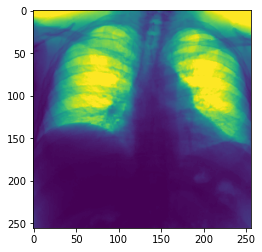

In [4]:
# Training

# Data augmentation transformations
data_transforms = {
    'train_transforms': tvtransforms.Compose([
    custom_transforms.RandomAutocontrast(sample_keys_images, cutoff_limits=(0.1,0.1)),
    custom_transforms.CenterCrop(sample_keys_images,256),
    custom_transforms.RandomHorizontalFlip(sample_keys_images, 0.5),
    custom_transforms.RandomAffine(sample_keys_images, degrees=10,translate=(0.1,0.1),scale=(0.9,1.1)),
    custom_transforms.ToTensor(sample_keys_images),
    custom_transforms.ImageComplement(sample_keys_images),
    ])
      ,
    'test_transforms': tvtransforms.Compose([
      custom_transforms.ToTensor(sample_keys_images),
    ]),
    }

# K-FOLD VALIDATION
splits=KFold(n_splits=split_k_folds,shuffle=True,random_state=42)
foldperf={}

print(target_key)
dataset = datasets.JSRT_CXR(data_normal, data_BSE, transform=None)
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('Fold {}'.format(fold + 1))
    history = {'loss':[], 'ssim_acc':[]}
    
    # Subset sample from dataset
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    dl_training = DataLoader(datasets.JSRT_CXR(data_normal, data_BSE, transform=data_transforms['train_transforms']),
                             batch_size=_batch_size, sampler=train_sampler, num_workers=0)
    dl_validation = DataLoader(datasets.JSRT_CXR(data_normal, data_BSE, transform=data_transforms['train_transforms']),
                             batch_size=_batch_size, sampler=test_sampler, num_workers=0)
    
    # Print example of transformed image
    for count, sample in enumerate(dl_training):
        image = sample["source"][0,:]
        image = torch.squeeze(image)
        plt.imshow(image)
        if count == 0:
            break

    ## Implementation of network and losses
    input_array_size = (_batch_size, 1, image_spatial_size[0], image_spatial_size[1])
    net = RajaramanModel.ResNet_BS(input_array_size)
    # Initialise weights
    net.apply(weights_init)

    # Multi-GPU
    if (device.type == 'cuda') and (ngpu > 1):
        print("Neural Net on GPU")
        net = nn.DataParallel(net, list(range(ngpu)))
    net = net.to(device)

    # Optimiser
    optimizer = optim.Adam(net.parameters(), lr=lr_ini, betas=(beta1, beta2))

    # Learning Rate Scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                     factor=0.5, patience=int(10*epoch_factor), 
                                                     threshold=0.0001, min_lr=0.00001, verbose=True)
    
    # For each epoch
    epochs_list = []
    img_list = []
    training_loss_list = []
    reals_shown = []
    #validation_loss_per_epoch_list = []
    #training_loss_per_epoch_list = []
    loss_per_epoch={"training":[], "validation":[]}
    ssim_average={"training":[], "validation":[]}


    # optionally resume from a checkpoint
    if flag_load_previous_save:
        if os.path.isfile(PATH_SAVE_NETWORK_INTERMEDIATE):
            print("=> loading checkpoint '{}'".format(PATH_SAVE_NETWORK_INTERMEDIATE))
            checkpoint = torch.load(PATH_SAVE_NETWORK_INTERMEDIATE)
            start_epoch = checkpoint['epoch_next']
            reals_shown_now = checkpoint['reals_shown']
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            net.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print("=> loaded checkpoint '{}' (epoch {}, reals shown {})".format(PATH_SAVE_NETWORK_INTERMEDIATE, 
                                                                                start_epoch, reals_shown_now))
            print(scheduler)
        else:
            print("=> NO CHECKPOINT FOUND AT '{}'" .format(PATH_SAVE_NETWORK_INTERMEDIATE))
            raise RuntimeError("No checkpoint found at specified path.")
    else:
        print("FLAG: NO CHECKPOINT LOADED.")
        reals_shown_now = 0
        start_epoch=0

    # Loop variables
    flag_break = False # when debugging, this will automatically go to True
    iters = 0
    net.train()
    for param in net.parameters():
        param.requires_grad = True
    for epoch in range(start_epoch, total_num_epochs):
        print(optimizer.param_groups[0]['lr'])
        sum_loss_in_epoch = 0
        for i, data in enumerate(dl_training):
            # Training
            net.zero_grad()
            noisy_data = data[original_key].to(device)
            cleaned_data = net(noisy_data)
            loss, maeloss, msssim_loss = criterion_Rajaraman(cleaned_data, data[target_key].to(device))
            loss.backward() # calculate gradients
            optimizer.step() # optimiser step along gradients

            # Output training stats
            if epoch % 1000 == 0:
                print('[%d/%d][%d/%d]\tTotal Loss: %.4f\tMAELoss: %.4f\tMSSSIM Loss: %.4f'
                      % (epoch, total_num_epochs, i, len(dl_training),
                         loss.item(), maeloss.item(), msssim_loss.item()))
            # Record generator output
            #if reals_shown_now%(100*_batch_size)==0:
            #    with torch.no_grad():
            #        val_cleaned = net(fixed_val_sample["source"].to(device)).detach().cpu()
            #    print("Printing to img_list")
            #    img_list.append(vutils.make_grid(val_cleaned, padding=2, normalize=True))
            #iters +=1
            #if flag_debug and iters>=10:
            #    flag_break = True
            #    break

            # Running counter of reals shown
            reals_shown_now += _batch_size
            reals_shown.append(reals_shown_now)

            # Training loss list for loss per minibatch
            training_loss_list.append(loss.item()) # training loss
            sum_loss_in_epoch += loss.item()*len(cleaned_data)
        # Turn the sum loss in epoch into a loss-per-epoch
        loss_per_epoch["training"].append(sum_loss_in_epoch/len(train_idx))


        with torch.no_grad():
            # Training Accuracy per EPOCH
            ssim_training_list = []
            for train_count, data in enumerate(dl_training):
                noisy_training_data = data[original_key].to(device)
                true_training_data = data[target_key]
                cleaned_training_data = net(noisy_training_data)

                for ii, image in enumerate(cleaned_training_data):
                    clean_training_numpy = image.cpu().detach().numpy()
                    true_training_numpy = true_training_data[ii].numpy()
                    clean_training_numpy = np.moveaxis(clean_training_numpy, 0, -1)
                    true_training_numpy = np.moveaxis(true_training_numpy, 0, -1)
                    ssim_training = skimage.metrics.structural_similarity(clean_training_numpy, true_training_numpy, multichannel=True)
                    ssim_training_list.append(ssim_training) # SSIM per image
            ssim_average["training"].append(np.mean(ssim_training_list))

            # Validation Loss and Accuracy per EPOCH
            sum_loss_in_epoch =0
            ssim_val_list = []
            for val_count, sample in enumerate(dl_validation):
                noisy_val_data = sample[original_key].to(device)
                cleaned_val_data = net(noisy_val_data)

                # Loss
                true_val_data = sample[target_key]
                val_loss, maeloss, msssim_loss = criterion_Rajaraman(cleaned_val_data, true_val_data.to(device))
                sum_loss_in_epoch += val_loss.item()*len(cleaned_val_data)

                # Accuracy
                for ii, image in enumerate(cleaned_val_data):
                    clean_val_numpy = image.cpu().detach().numpy()
                    true_val_numpy = true_val_data[ii].numpy()
                    clean_val_numpy = np.moveaxis(clean_val_numpy, 0, -1)
                    true_val_numpy = np.moveaxis(true_val_numpy, 0, -1)
                    ssim_val = skimage.metrics.structural_similarity(clean_val_numpy, true_val_numpy, multichannel=True)
                    ssim_val_list.append(ssim_val) # SSIM per image
            # After considering all validation images
            loss_per_epoch["validation"].append(sum_loss_in_epoch/len(val_idx))
            ssim_average["validation"].append(np.mean(ssim_val_list))
        epochs_list.append(epoch)
        # LR Scheduler after epoch
        scheduler.step(val_loss)

        # Save the network in indications
        #if epoch % 5 == 0:
        #    if not flag_debug:
        #        #torch.save(net.state_dict(), PATH_SAVE_NETWORK_INTERMEDIATE)
        #        torch.save({
        #        'epochs_completed': epoch+1,
        #        'epoch_next': epoch+1,
        #        'model_state_dict': net.state_dict(),
        #        'optimizer_state_dict': optimizer.state_dict(),
        #        'loss': loss,
        #        'scheduler_state_dict': scheduler.state_dict(),
        #        'reals_shown': reals_shown_now
        #        }, PATH_SAVE_NETWORK_INTERMEDIATE)
        #        print("Saved Intermediate: "+ str(PATH_SAVE_NETWORK_INTERMEDIATE))
        #if flag_break:
        #    break
        
    #After all epochs, save results:
    history["loss"] = loss_per_epoch
    history["ssim_acc"] = ssim_average
    
    foldperf['fold{}'.format(fold+1)] = history
    
    # Final Save for each fold
    if not flag_debug:
        torch.save({
                'epochs_completed': epoch+1,
                'epoch_next': epoch+1,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'scheduler_state_dict': scheduler.state_dict(),
                'reals_shown': reals_shown_now
                }, PATH_SAVE_NETWORK_INTERMEDIATE.format(fold+1))
        print("Saved Intermediate: "+ str(PATH_SAVE_NETWORK_INTERMEDIATE.format(fold+1)))
    

Training complete
Performance of 10 fold cross validation
Average Training Loss: 0.018 	 Average Test Loss: 0.017 	 Average Training Acc: 0.976 	 Average Test Acc: 0.976
Best fold: 5


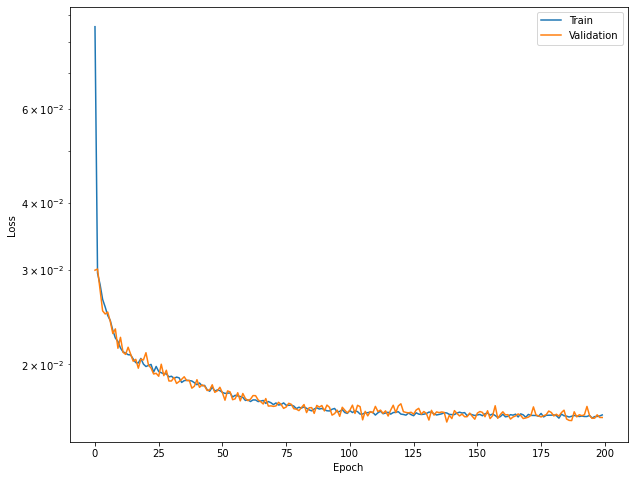

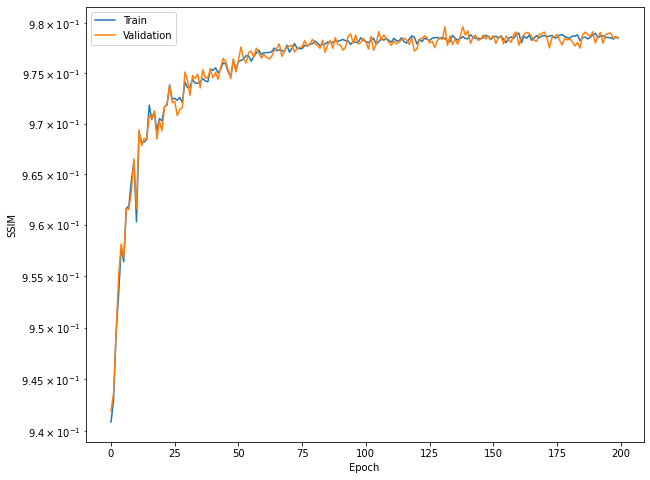

In [5]:
print("Training complete")
# Find the best fold


# AVERAGE PERFORMANCE
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=10
for f in range(1,k+1):
    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['loss']['training']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['loss']['validation']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['ssim_acc']['training']))
    testa_f.append(np.mean(foldperf['fold{}'.format(f)]['ssim_acc']['validation']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}"
      .format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))
print("Best fold: {}".format(np.argmax(testa_f)+1))

# Averaging accuracy and loss
diz_ep = {'train_loss_ep':[],'test_loss_ep':[],'train_acc_ep':[],'test_acc_ep':[]}
for i in range(total_num_epochs):
    diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['loss']['training'][i] for f in range(k)]))
    diz_ep['test_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['loss']['validation'][i] for f in range(k)]))
    diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['ssim_acc']['training'][i] for f in range(k)]))
    diz_ep['test_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['ssim_acc']['validation'][i] for f in range(k)]))

# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_loss_ep'], label='Train')
plt.semilogy(diz_ep['test_loss_ep'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_loss"+".png"))
plt.show()

# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_acc_ep'], label='Train')
plt.semilogy(diz_ep['test_acc_ep'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
#plt.grid()
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_accuracy"+".png"))
plt.show()

NameError: name 'fixed_val_sample' is not defined

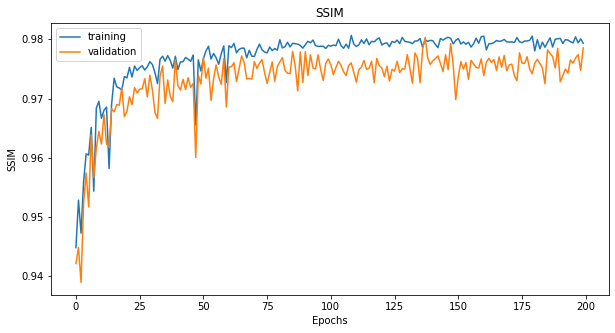

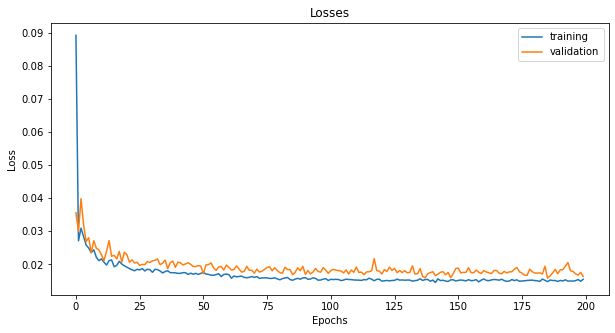

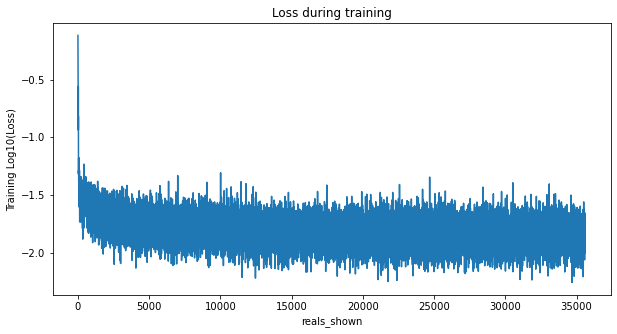

In [6]:
%matplotlib inline
import math
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

# Accuracy
plt.figure(figsize=(10,5))
plt.title("SSIM")
plt.plot(epochs_list, ssim_average["training"], label='training')
plt.plot(epochs_list, ssim_average["validation"] , label='validation')
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_accuracy"+".png"))
    
# All losses
plt.figure(figsize=(10,5))
plt.title("Losses")
plt.plot(epochs_list, loss_per_epoch["training"], label='training')
plt.plot(epochs_list, loss_per_epoch["validation"] , label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_loss"+".png"))

# Loss for training
plt.figure(figsize=(10,5))
plt.title("Loss during training")
plt.plot(reals_shown, [math.log10(y) for y in training_loss_list])
plt.xlabel("reals_shown")
plt.ylabel("Training Log10(Loss)")
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_training_loss"+".png"))


    
# Final Model:
with torch.no_grad():
    input_image = fixed_val_sample['source']
    input_images = vutils.make_grid(input_image[0:1,:,:,:], padding=2, normalize=True)
    target_images = vutils.make_grid(fixed_val_sample['boneless'][0:1,:,:,:], padding=2, normalize=True)
    net = net.cpu()
    output_image = net(input_image[0:1,:,:,:]).detach().cpu()
    output_images = vutils.make_grid(output_image, padding=2, normalize=True)
print(str(torch.max(output_images)) + "," + str(torch.min(output_images)))
plt.figure(1)
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(np.transpose(input_images, (1,2,0)), vmin=0, vmax=1)
ax[0].set_title("Source")
ax[0].axis("off")
ax[1].imshow(np.transpose(output_images, (1,2,0)), vmin=0, vmax=1)
ax[1].set_title("Suppressed")
ax[1].axis("off")
ax[2].imshow(np.transpose(target_images, (1,2,0)), vmin=0, vmax=1)
ax[2].set_title("Ideal Bone-suppressed")
ax[2].axis("off")
plt.show
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_validation_ComparisonImages"+".png"))

# ANIMATED VALIDATION IMAGE
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.axis("off")
ims = []
training_ims_shown = []
for i, im in enumerate(img_list):
    if i % 50 == 0:  # controls how many images are printed into the animation
        training_ims_shown = i*(100*_batch_size)
        frame = ax.imshow(np.transpose(im,(1,2,0)))
        t = ax.annotate("Reals shown: {}".format(training_ims_shown), (0.5,1.02), xycoords="axes fraction")
        ims.append([frame, t])
ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)
if not flag_debug:
    ani.save(os.path.join(output_save_directory, current_date+"_animation.mp4"), dpi=300)

In [ ]:
clean_matrix = torch.from_numpy(np.random.rand(15,1,256,256)).float()
true_matrix = torch.from_numpy(np.random.rand(15,1,256,256)).float()
print(criterion_Rajaraman(clean_matrix, true_matrix, alpha=0.84))
print(len(true_matrix))
print(len(ds_training))

In [ ]:
ssim_average["validation"]